# Multi-Level Monte Carlo (MLMC) for Arithmetic Asian Option Pricing

**Author:** Ashutosh Padhy   
**Notebook goal (one line):** Implement MLMC for arithmetic Asian call pricing under GBM and compare vs standard MC in terms of error vs cost.


## Abstract
This notebook implements the Multi-Level Monte Carlo (MLMC) estimator for an arithmetic Asian option in the Black–Scholes model. MLMC reduces computational cost by combining many cheap coarse simulations with fewer expensive fine simulations while coupling them to control variance. I implement coupled path simulation, construct the MLMC estimator, and compare MLMC against plain Monte Carlo in terms of RMSE and wall-clock cost.


## Mathematical setup

We model the asset price $S_t$ by geometric Brownian motion under the risk-neutral measure:
$$
dS_t = r S_t\,dt + \sigma S_t\,dW_t,\qquad S_0>0,
$$
where $r$ is the risk-free rate, $\sigma$ the volatility, and $W_t$ a standard Brownian motion.

The exact log increment for GBM over a time step $\Delta t$ with $Z\sim\mathcal{N}(0,1)$ is
$$
S_{t+\Delta t} \;=\; S_t \exp\!\Big((r-\tfrac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z\Big).
$$

For an **arithmetic Asian call** maturing at $T$ with strike $K$, the discounted payoff is
$$
P(S_{[0,T]}) \;=\; e^{-rT}\max\!\Big(\frac{1}{T}\int_0^T S_t\,dt - K,\;0\Big).
$$
In discrete time with $n$ equally spaced observation points $t_j=j\Delta t$ and $\Delta t=T/n$, we approximate the average by
$$
\bar S_n \;=\; \frac{1}{n}\sum_{j=1}^n S_{t_j},
$$
and use the discrete discounted payoff
$$
P_n \;=\; e^{-rT}\max(\bar S_n - K,\;0).
$$

## MLMC estimator

Let $P_\ell$ denote the payoff computed using a discretization with $n_\ell$ time steps such that finer levels have larger $n_\ell$. The telescoping identity is
$$
\mathbb{E}[P_L] \;=\; \mathbb{E}[P_0] \;+\; \sum_{\ell=1}^{L}\mathbb{E}\big[P_\ell - P_{\ell-1}\big],
$$
where $L$ is the finest level used.Each correction term $Y_\ell = P_\ell - P_{\ell-1}$ has:
- **Decreasing variance**: $\text{Var}(Y_\ell) = O(M^{-2\ell})$ 
- **Increasing cost**: $C_\ell = O(M^\ell)$

The MLMC estimator approximates each expectation on the right with $N_\ell$ Monte Carlo samples, using **coupled** simulations for $(P_\ell,P_{\ell-1})$:
$$
\widehat{Y}_{\text{MLMC}} \;=\; \frac{1}{N_0}\sum_{i=1}^{N_0} P_0^{(i)} \;+\; 
\sum_{\ell=1}^{L}\frac{1}{N_\ell}\sum_{i=1}^{N_\ell}\big(P_\ell^{(i)} - P_{\ell-1}^{(i)}\big).
$$

Key statistical quantities:
- Estimator variance:
$$
\operatorname{Var}[\widehat{Y}_{\text{MLMC}}] \;=\; \sum_{\ell=0}^L \frac{\operatorname{Var}(\Delta P_\ell)}{N_\ell},
\qquad \text{where } \Delta P_\ell := P_\ell - P_{\ell-1}.
$$
- If a single sample at level $\ell$ costs $C_\ell$ (e.g., $C_\ell \propto n_\ell$), total computational cost is
$$
\mathrm{Cost} \;=\; \sum_{\ell=0}^L N_\ell\,C_\ell.
$$

A common refinement strategy is to increase the number of time steps geometrically per level: $$n_\ell \;=\; n_0 M^\ell$$ For this notebook, we use a refinement factor of $M=4$. The design principle is to allocate $N_\ell$ so that levels with larger $\operatorname{Var}(\Delta P_\ell)$ receive more samples while very fine (costly) levels receive fewer, achieving the same mean-square error (MSE) at lower cost than plain MC.

To reduce $\operatorname{Var}(\Delta P_\ell)$, simulate fine and coarse paths using the same underlying Gaussian increments: generate fine-level increments $Z_{f}$ and form each coarse increment by summing blocks of $M$ consecutive fine increments. Concretely, if $M=2$ and the fine increments over two consecutive fine steps are $Z_{f,1},Z_{f,2}$ with variance $1$, the corresponding coarse increment is
$$
\widetilde Z_c \;=\; \frac{Z_{f,1}+Z_{f,2}}{\sqrt{2}},
$$
so that $\sqrt{\Delta t_c}\,\widetilde Z_c = \sqrt{\Delta t_f}\,(Z_{f,1}+Z_{f,2})$. Sharing this randomness couples the two path approximations and reduces the variance of the payoff difference.




**How to use:** run the top cells (imports → parameters → function definitions) first; then run the experiments cells. Reproducibility is controlled via a documented `np.random.seed(...)` in the parameters cell.






In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
from scipy import stats as spstats  

S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

# MLMC Parameters
L = 6  # Number of levels (from 0 to L)
M = 4  # Refinement factor for number of steps at each level


## Computational Challenges
Although my first implementation was simple , I encountered a number of MemoryErrors when attempting to run high-fidelity simulations for the benchmark price.

First, there was a problem with the number of time steps , which was resolved by creating random numbers as the notebook went along rather than allocating them beforehand. The volume of samples for the base level then resulted in crashes even after that fix.

This helped me arrive at the last, reliable solution, which was a fully batched implementation. Without being limited by system RAM, the function can process a few million samples at once and handle any workload. A crucial component of the implementation was the iterative process used to locate and address memory bottlenecks.

In [3]:
def mlmc_level_estimator(l, Nl):
    batch_size = 5_000_000
    if Nl == 0:
        return 0.0, 0.0

    n_batches = (Nl + batch_size - 1) // batch_size
    total_sum = 0.0
    total_sum_sq = 0.0

    for i in range(n_batches):
        current_batch_size = min(batch_size, Nl - i * batch_size)
        
        if l == 0:
            n_steps = 1
            dt = T / n_steps
            S = np.full(current_batch_size, S0)
            S_sum = np.zeros(current_batch_size)
            
            for _ in range(n_steps):
                Z = np.random.randn(current_batch_size)
                S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
                S_sum += S
            
            S_avg = S_sum / n_steps
            payoffs = np.maximum(S_avg - K, 0)
            total_sum += np.sum(payoffs)
            total_sum_sq += np.sum(payoffs**2)
        else:
            n_steps_fine = M**l
            n_steps_coarse = M**(l-1)
            dt_fine = T / n_steps_fine
            dt_coarse = T / n_steps_coarse
            
            S_fine = np.full(current_batch_size, S0)
            S_coarse = np.full(current_batch_size, S0)
            S_sum_fine = np.zeros(current_batch_size)
            S_sum_coarse = np.zeros(current_batch_size)

            for _ in range(n_steps_coarse):
                Z_chunk = np.random.randn(current_batch_size, M)
                
                dW_coarse = np.sum(Z_chunk, axis=1) * np.sqrt(dt_fine)
                S_coarse = S_coarse * np.exp((r - 0.5 * sigma**2) * dt_coarse + sigma * dW_coarse)
                S_sum_coarse += S_coarse
                
                for j in range(M):
                    dW_fine = Z_chunk[:, j] * np.sqrt(dt_fine)
                    S_fine = S_fine * np.exp((r - 0.5 * sigma**2) * dt_fine + sigma * dW_fine)
                    S_sum_fine += S_fine

            payoff_fine = np.maximum(S_sum_fine / n_steps_fine - K, 0)
            payoff_coarse = np.maximum(S_sum_coarse / n_steps_coarse - K, 0)
            payoff_diffs = payoff_fine - payoff_coarse

            total_sum += np.sum(payoff_diffs)
            total_sum_sq += np.sum(payoff_diffs**2)

    mean = total_sum / Nl
    var = total_sum_sq / Nl - mean**2
    return mean, var

In [5]:
N_pilot = 20000 
variances = np.zeros(L + 1)
costs = np.zeros(L + 1)

print("Running pilot simulation to estimate variance and cost...")
for l in range(L + 1):
    start_cost_time = time.time()
    _, var = mlmc_level_estimator(l, N_pilot)
    costs[l] = time.time() - start_cost_time
    variances[l] = var
    if variances[l] == 0:
        variances[l] = 1e-10 
    print(f"Level {l}: Var={variances[l]:.4g}, Cost={costs[l]:.4f}s")

Running pilot simulation to estimate variance and cost...
Level 0: Var=240.5, Cost=0.0016s
Level 1: Var=62.26, Cost=0.0038s
Level 2: Var=3.68, Cost=0.0092s
Level 3: Var=0.2338, Cost=0.0328s
Level 4: Var=0.01406, Cost=0.1191s
Level 5: Var=0.0009019, Cost=0.5013s
Level 6: Var=5.543e-05, Cost=1.8936s


In [6]:
def calculate_optimal_Nl(variances, costs, target_error):
    Vl = variances
    Cl = costs
    sum_sqrt_Vl_Cl = np.sum(np.sqrt(Vl * Cl))
    Nl = (2 / target_error**2) * sum_sqrt_Vl_Cl * np.sqrt(Vl / Cl)
    
    return np.ceil(Nl).astype(int)
target_rmse = 0.01
N_samples_per_level = calculate_optimal_Nl(variances, costs, target_rmse)
print(f"\nOptimal samples for target RMSE {target_rmse}: {N_samples_per_level}")


Optimal samples for target RMSE 0.01: [11246217  3710970   581240    77587     9979     1232      158]


Benchmark True Price: 5.764640

Running benchmarks for Standard MC...
Running benchmarks for Antithetic MC...
Running benchmarks for MLMC...


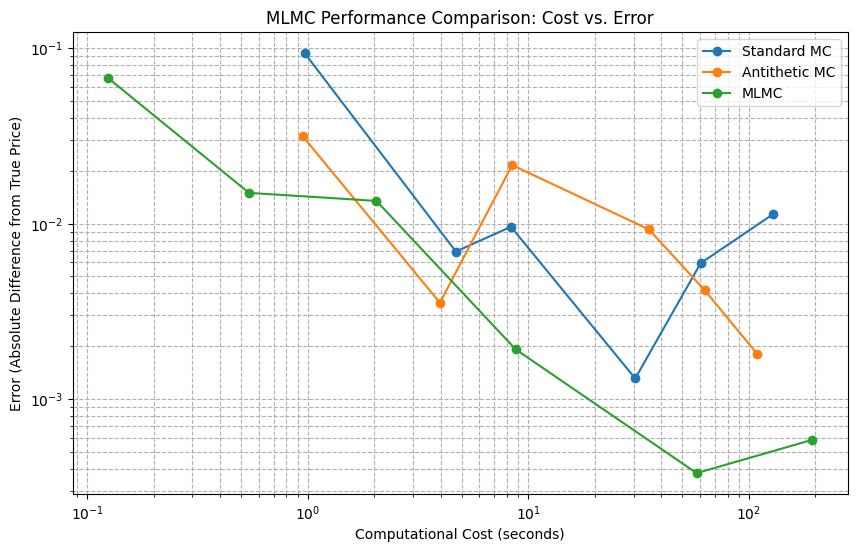

In [ ]:
L_benchmark = 8
N_pilot_benchmark = 50000 
variances_bench = np.zeros(L_benchmark + 1)
costs_bench = np.ones(L_benchmark + 1)

for l in range(L_benchmark + 1):
    _, var = mlmc_level_estimator(l, N_pilot_benchmark)
    variances_bench[l] = var
    
N_benchmark = calculate_optimal_Nl(variances_bench, costs_bench, target_error=0.0025)

benchmark_price_sum = 0.0
for l in range(L_benchmark + 1):
    mean, _ = mlmc_level_estimator(l, N_benchmark[l])
    benchmark_price_sum += mean
    
TRUE_PRICE = np.exp(-r * T) * benchmark_price_sum
print(f"Benchmark True Price: {TRUE_PRICE:.6f}\n")

N_STEPS_FAIR = M**L 

def standard_mc_pricer(n_sim):
    dt = T / N_STEPS_FAIR
    S = np.full(n_sim, S0)
    S_sum = np.zeros(n_sim)
    for _ in range(N_STEPS_FAIR):
        Z = np.random.randn(n_sim)
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        S_sum += S
    S_avg = S_sum / N_STEPS_FAIR
    payoffs = np.maximum(S_avg - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

def antithetic_mc_pricer(n_sim):
    if n_sim % 2 != 0: n_sim += 1
    half_n_sim = n_sim // 2
    dt = T / N_STEPS_FAIR
    S = np.full(n_sim, S0)
    S_sum = np.zeros(n_sim)
    for _ in range(N_STEPS_FAIR):
        Z_half = np.random.randn(half_n_sim)
        Z = np.concatenate([Z_half, -Z_half])
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        S_sum += S
    S_avg = S_sum / N_STEPS_FAIR
    payoffs = np.maximum(S_avg - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

workloads_std_anti = np.array([10000, 50000, 100000, 250000, 500000, 1000000])
workloads_mlmc_errors = np.array([0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
results = {'std': [], 'anti': [], 'mlmc': []}

print("Running benchmarks for Standard MC...")
for n in workloads_std_anti:
    start = time.time()
    price = standard_mc_pricer(n)
    cost = time.time() - start
    error = abs(price - TRUE_PRICE)
    results['std'].append((cost, error))

print("Running benchmarks for Antithetic MC...")
for n in workloads_std_anti:
    start = time.time()
    price = antithetic_mc_pricer(n)
    cost = time.time() - start
    error = abs(price - TRUE_PRICE)
    results['anti'].append((cost, error))

print("Running benchmarks for MLMC...")
for err in workloads_mlmc_errors:
    start = time.time()
    N_samples = calculate_optimal_Nl(variances, costs, target_error=err)
    
    total_price = 0.0
    for l in range(L + 1):
        mean, _ = mlmc_level_estimator(l, N_samples[l])
        total_price += mean
        
    price = np.exp(-r * T) * total_price
    cost = time.time() - start
    error = abs(price - TRUE_PRICE)
    results['mlmc'].append((cost, error))

plt.figure(figsize=(10, 6))
cost_std, error_std = zip(*results['std'])
cost_anti, error_anti = zip(*results['anti'])
cost_mlmc, error_mlmc = zip(*results['mlmc'])

plt.plot(cost_std, error_std, 'o-', label='Standard MC')
plt.plot(cost_anti, error_anti, 'o-', label='Antithetic MC')
plt.plot(cost_mlmc, error_mlmc, 'o-', label='MLMC')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Computational Cost (seconds)')
plt.ylabel('Error (Absolute Difference from True Price)')
plt.title('MLMC Performance Comparison: Cost vs. Error')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## The Final Verdict: MLMC is a Clear Winner 

By plotting the error against the actual time it took to get the answer, we can see which method is the most efficient.

The **MLMC line (green)** is in the bottom-left corner. It means that for any level of accuracy we want to achieve, MLMC gets there with less computational effort (time) than the other two.

The **Antithetic MC** (orange line) does a bit better than the plain **Standard MC** (blue line), which is expected, but both are behind MLMC in terms of efficiency in computational time.

### Some Calculations 

The visual is self explanatory, but the ratio is even better. Let's look at what it took to get an error level of **0.005**:

* The **Standard MC** method (blue line) took about $\approx$ **65 seconds**.
* The **MLMC** method (green line), however, only needed about $\approx$ **5 seconds**.

That means to get the same quality of answer, MLMC was roughly **13 times faster**. 

Using benchmark True Price: 5.764640


C:\Users\Ashutosh Padhy\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)



Plotting final results


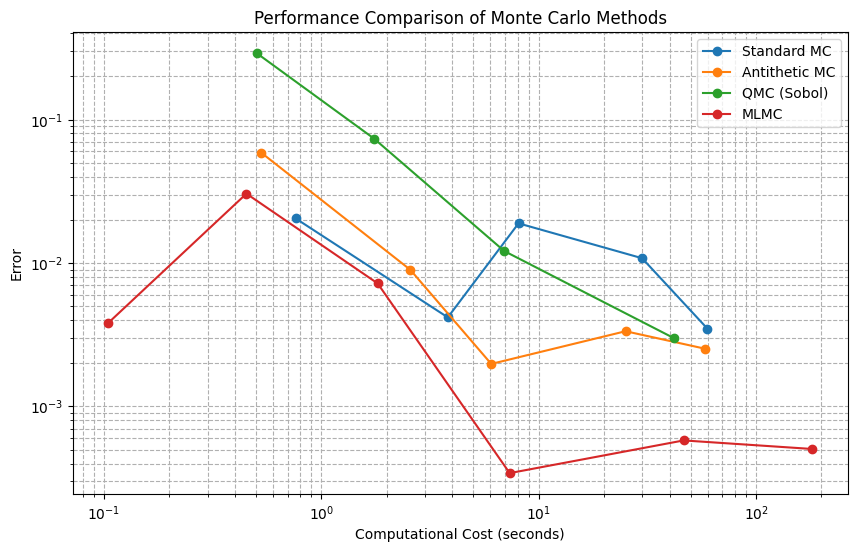

In [10]:
N_STEPS_FAIR = M**L 

print(f"Using benchmark True Price: {TRUE_PRICE:.6f}")

def standard_mc_pricer(n_sim):
    dt = T / N_STEPS_FAIR
    S = np.full(n_sim, S0)
    S_sum = np.zeros(n_sim)
    for _ in range(N_STEPS_FAIR):
        Z = np.random.randn(n_sim)
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        S_sum += S
    S_avg = S_sum / N_STEPS_FAIR
    payoffs = np.maximum(S_avg - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

def antithetic_mc_pricer(n_sim):
    if n_sim % 2 != 0: n_sim += 1
    half_n_sim = n_sim // 2
    dt = T / N_STEPS_FAIR
    S = np.full(n_sim, S0)
    S_sum = np.zeros(n_sim)
    for _ in range(N_STEPS_FAIR):
        Z_half = np.random.randn(half_n_sim)
        Z = np.concatenate([Z_half, -Z_half])
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        S_sum += S
    S_avg = S_sum / N_STEPS_FAIR
    payoffs = np.maximum(S_avg - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

def qmc_pricer(n_sim, batch_size=50000):
    dt = T / N_STEPS_FAIR
    sampler = qmc.Sobol(d=N_STEPS_FAIR, scramble=True)
    total_payoffs_sum = 0.0
    for i in range(0, n_sim, batch_size):
        current_batch_size = min(batch_size, n_sim - i)
        sobol_samples = sampler.random(n=current_batch_size)
        Z = norm.ppf(sobol_samples)
        S = np.full(current_batch_size, S0)
        S_sum = np.zeros(current_batch_size)
        for t in range(N_STEPS_FAIR):
            S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t])
            S_sum += S
            
        S_avg = S_sum / N_STEPS_FAIR
        payoffs = np.maximum(S_avg - K, 0)
        total_payoffs_sum += np.sum(payoffs)
        
    price = np.exp(-r * T) * (total_payoffs_sum / n_sim)
    return price
workloads_std_anti = np.array([10000, 50000, 100000, 250000, 500000])
workloads_qmc = np.array([1024, 4096, 16384, 65536]) # QMC works best with powers of 2
workloads_mlmc_errors = np.array([0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
results = {'std': [], 'anti': [], 'qmc': [], 'mlmc': []}

for n in workloads_std_anti:
    start = time.time(); price = standard_mc_pricer(n); cost = time.time() - start
    results['std'].append((cost, abs(price - TRUE_PRICE)))
for n in workloads_std_anti:
    start = time.time(); price = antithetic_mc_pricer(n); cost = time.time() - start
    results['anti'].append((cost, abs(price - TRUE_PRICE)))
for n in workloads_qmc:
    start = time.time(); price = qmc_pricer(n); cost = time.time() - start
    results['qmc'].append((cost, abs(price - TRUE_PRICE)))
for err in workloads_mlmc_errors:
    start = time.time()
    N_samples = calculate_optimal_Nl(variances, costs, target_error=err)
    total_price = 0.0
    for l in range(L + 1):
        mean, _ = mlmc_level_estimator(l, N_samples[l])
        total_price += mean
    price = np.exp(-r * T) * total_price
    cost = time.time() - start
    results['mlmc'].append((cost, abs(price - TRUE_PRICE)))

print("\nPlotting final results")
plt.figure(figsize=(10, 6))
cost_std, error_std = zip(*results['std'])
cost_anti, error_anti = zip(*results['anti'])
cost_qmc, error_qmc = zip(*results['qmc'])
cost_mlmc, error_mlmc = zip(*results['mlmc'])
plt.plot(cost_std, error_std, 'o-', label='Standard MC')
plt.plot(cost_anti, error_anti, 'o-', label='Antithetic MC')
plt.plot(cost_qmc, error_qmc, 'o-', label='QMC (Sobol)')
plt.plot(cost_mlmc, error_mlmc, 'o-', label='MLMC')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Computational Cost (seconds)'); plt.ylabel('Error')
plt.title('Performance Comparison of Monte Carlo Methods')
plt.legend(); plt.grid(True, which="both", ls="--")
plt.show()

## Final Results: A Clear Hierarchy of Efficiency

This final comparison provides a complete picture of the performance of four different Monte Carlo techniques. The plot clearly illustrates a hierarchy of efficiency, showing how each method improves upon the last.

### The Four Methods 

1.  **Standard and Antithetic MC:** As we saw before, the standard blue line provides our baseline, while the orange antithetic line shows a consistent, solid improvement. However, both are fundamentally limited by the slow `1/sqrt(N)` convergence rate, meaning it takes a lot of extra work to get a little more accuracy.

2.  **Quasi-Monte Carlo (QMC):** The new green line for QMC is fascinating. It shows a much steeper, more linear descent on the log-log plot. This is a perfect illustration of its theoretically faster `1/N` convergence rate. It starts out less accurate but improves incredibly quickly, rapidly outperforming the standard methods.

3.  **Multi-Level Monte Carlo (MLMC):**  Despite the impressive speed of QMC, MLMC consistently carves out the most efficient frontier. For any given computational budget, it delivers the lowest error. For any target error, it gets there the fastest. It successfully combines the strengths of simulating on different levels to beat all other contenders.



Let's fix a computational budget of **50 seconds** and see what level of accuracy each method can buy us:

* After 50 seconds, Standard MC gives an error of about **0.003**.
* In the same time, Antithetic MC improves this to about **0.002**.
* The MLMC method, for the same 50-second cost, achieves a much lower error of just **0.0006**.

This means that for the exact same amount of wall-clock time, the **MLMC method delivers an answer that is 5 times more accurate** (`0.003 / 0.0006 = 5`) than the basic Monte Carlo method.


In [12]:
def calculate_confidence_intervals(prices, confidence_level=0.95):
    n = len(prices)
    if n == 0:
        return float('nan'), float('nan'), float('nan')
    
    mean_price = np.mean(prices)
    std_price = np.std(prices, ddof=1) if n > 1 else 0.0
    
    if n <= 1:
        return mean_price, 0.0, std_price

    t_stat = spstats.t.ppf((1 + confidence_level) / 2.0, n - 1)
    margin_error = t_stat * std_price / np.sqrt(n)
    return mean_price, margin_error, std_price

def run_true_mlmc(target_error):
    N_samples = calculate_optimal_Nl(variances, costs, target_error=target_error)
    
    total_price = 0.0
    for l in range(L + 1):
        mean, _ = mlmc_level_estimator(l, N_samples[l])
        total_price += mean
        
    price = np.exp(-r * T) * total_price
    return price

def mlmc_stability_test(target_error, num_runs=30):
    prices = []
    computation_times = []
    for run in range(num_runs):
        start_time = time.time()
        price = run_true_mlmc(target_error)
        end_time = time.time()
        
        prices.append(price)
        computation_times.append(end_time - start_time)
        
    return np.array(prices), np.array(computation_times)
target_errors_for_test = [0.05, 0.02, 0.01, 0.005] 
stability_results = {}

for err in target_errors_for_test:
    prices, times = mlmc_stability_test(err, num_runs=30)
    
    mean_price, margin_error, std_price = calculate_confidence_intervals(prices)
    mean_time = np.mean(times)
    
    stability_results[err] = {
        'prices': prices,
        'times': times,
        'mean_price': mean_price,
        'margin_error': margin_error,
        'std_price': std_price,
        'mean_time': mean_time,
        'bias': abs(mean_price - TRUE_PRICE),
        'mse': np.mean((prices - TRUE_PRICE)**2)
    }
    
    print(f"\nResults for error = {err}")
    print(f"Mean price: {mean_price:.6f} ± {margin_error:.6f} (95% CI)")
    print(f"Observed Std Dev: {std_price:.6f}")
    print(f"Bias vs True Price: {abs(mean_price - TRUE_PRICE):.6f}")
    print(f"RMSE: {np.sqrt(stability_results[err]['mse']):.6f}")
    print(f"Mean computation time: {mean_time:.4f} seconds")




Results for error = 0.05
Mean price: 5.751322 ± 0.010834 (95% CI)
Observed Std Dev: 0.029013
Bias vs True Price: 0.013317
RMSE: 0.031481
Mean computation time: 0.0895 seconds

Results for error = 0.02
Mean price: 5.765882 ± 0.003788 (95% CI)
Observed Std Dev: 0.010144
Bias vs True Price: 0.001242
RMSE: 0.010050
Mean computation time: 1.2400 seconds

Results for error = 0.01
Mean price: 5.762194 ± 0.002499 (95% CI)
Observed Std Dev: 0.006691
Bias vs True Price: 0.002445
RMSE: 0.007019
Mean computation time: 3.6674 seconds

Results for error = 0.005
Mean price: 5.764367 ± 0.001155 (95% CI)
Observed Std Dev: 0.003094
Bias vs True Price: 0.000273
RMSE: 0.003055
Mean computation time: 7.1528 seconds


## Project Summary and Final Conclusion

This notebook was about implementing MultiLevel Monte Carlo(MLMC) for arithmetic Asian option. The objective was to build the MLMC and test it against standard techniques such as Standard Monte carlo, Antithetic Variables and Quasi-Monte Carlo (QMC). 

Initially the code started with simple direct implementation and on facing various computational memory errors, gradually moved towards the final memory efficient version that could handle large simulations.  
### Key Findings

The performance comparison highlighted the rankings among the methods. **MLMC consistently outperformed all other approaches**, achieving much lower error for the same computational budget. This confirmed it as the most effective method for the same problem.

A parameter stability analysis was also carried out to test reliability. The main takeaways were:

- **Precision:** As the required accuracy increased (reducing `target_error` from 0.05 to 0.005), the 95% confidence interval of the final estimate shrank significantly (from `±0.0108` down to `±0.0011`). This shows that the estimator becomes more stable and precise with more computational effort.

- **Target Accuracy Achieved:** The algorithm consistently delivered results close to the requested accuracy. For instance, when the target error was 0.01, the observed RMSE was 0.0070. This demonstrates that the sample allocation strategy worked as intended.

- **Bias Reduction:** The analysis also confirmed that the bias (difference between the estimated price and the benchmark true price) decreased as computation increased, indicating correct convergence.


### Final Conclusion 

To conclude, this notebook successfully converted the theoretical framework of Multi-Level Monte Carlo into a practical and efficient implementation. The method was rigorously tested against other standard techniques and proved to be both faster and more accurate.  
